# Demixed PLS (dPLS) Tutorial

## What is Demixed PLS?

**Demixed PLS** combines the marginalization concept from dPCA with the supervised nature of Partial Least Squares (PLS).

## dPCA vs dPLS: Key Differences

| Aspect | dPCA | dPLS |
|--------|------|------|
| **Objective** | Maximize **variance** per marginalization | Maximize **covariance with Y** per marginalization |
| **Supervision** | Unsupervised (no target) | Supervised (uses mental scores) |
| **Question answered** | "What patterns exist in the data?" | "What patterns predict mental state?" |
| **Components** | Explain most variance | Explain most covariance with target |
| **Best for** | Exploratory analysis | Prediction, association finding |

## Mathematical Comparison

```
dPCA:  Find W that maximizes Var(W'X_φ) for each marginalization φ
dPLS:  Find W that maximizes Cov(W'X_φ, Y) for each marginalization φ
```

## When to Use Which?

- **dPCA**: Explore what patterns exist in gait data across mental states
- **dPLS**: Find gait patterns that specifically predict mental scores

In [1]:
# Setup
import sys
from pathlib import Path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.dpca import DemixedPCA, DemixedPLS

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
print("Setup complete!")

Setup complete!


## 1. Generate Data with Known Mental Score Structure

We'll create synthetic gait data where some features are associated with mental scores.

In [2]:
# Generate synthetic data
np.random.seed(42)

n_features = 15
n_timepoints = 100
n_conditions = 5
n_mental_vars = 4

# Labels
feature_labels = [
    'hip_flexion', 'hip_abduction', 'knee_flexion', 'ankle_dorsiflexion',
    'pelvis_tilt', 'pelvis_obliquity', 'trunk_flexion', 'trunk_rotation',
    'stride_length', 'step_width', 'cadence', 'grf_vertical', 
    'grf_anterior', 'grf_lateral', 'com_velocity'
]
condition_labels = ['neutral', 'anxious', 'relaxed', 'focused', 'fatigued']
mental_labels = ['wellbeing', 'anxiety', 'stress', 'fatigue']

# MULTIVARIATE Mental scores (Y): [n_conditions, n_mental_vars]
mental_scores = np.array([
    # wellbeing, anxiety, stress, fatigue
    [5.0, 4.0, 4.0, 4.0],   # neutral
    [3.0, 8.0, 7.0, 5.0],   # anxious
    [8.0, 2.0, 2.0, 3.0],   # relaxed
    [6.0, 5.0, 4.0, 3.0],   # focused
    [4.0, 5.0, 6.0, 8.0],   # fatigued
])

print("=== MULTIVARIATE Mental Scores ===")
print(f"Shape: {mental_scores.shape} = [n_conditions, n_mental_vars]")
print(f"\n{'Condition':<12} | " + " | ".join(f'{m:>10}' for m in mental_labels))
print("-" * 65)
for label, scores in zip(condition_labels, mental_scores):
    print(f"{label:<12} | " + " | ".join(f'{s:>10.1f}' for s in scores))

=== MULTIVARIATE Mental Scores ===
Shape: (5, 4) = [n_conditions, n_mental_vars]

Condition    |  wellbeing |    anxiety |     stress |    fatigue
-----------------------------------------------------------------
neutral      |        5.0 |        4.0 |        4.0 |        4.0
anxious      |        3.0 |        8.0 |        7.0 |        5.0
relaxed      |        8.0 |        2.0 |        2.0 |        3.0
focused      |        6.0 |        5.0 |        4.0 |        3.0
fatigued     |        4.0 |        5.0 |        6.0 |        8.0


In [3]:
# Generate gait data X: [n_features, n_timepoints, n_conditions]
t = np.linspace(0, 2*np.pi, n_timepoints)
data = np.zeros((n_features, n_timepoints, n_conditions))

# Define which features are associated with which mental variables
feature_mental_mapping = {
    'wellbeing': [0, 2, 8, 14],      # hip, knee, stride, com_velocity
    'anxiety': [4, 5, 6, 7],          # pelvis, trunk (postural stability)
    'stress': [10, 11, 12],           # cadence, grf (movement intensity)
    'fatigue': [8, 9, 10, 14],        # stride, step_width, cadence, com_velocity
}

for f in range(n_features):
    for c in range(n_conditions):
        # Time component (gait cycle)
        time_component = np.sin(t + f * 0.3) + 0.5 * np.cos(2*t + f * 0.2)
        
        # Mental-dependent effects
        condition_effect = 0
        for m_idx, (mental_var, affected_features) in enumerate(feature_mental_mapping.items()):
            if f in affected_features:
                sign = 1 if mental_var == 'wellbeing' else -1
                condition_effect += sign * 0.3 * (mental_scores[c, m_idx] - mental_scores[:, m_idx].mean())
        
        # Interaction
        interaction = 0.2 * np.sin(t + c * 0.5) * (1 if f < 5 else 0.1)
        
        # Noise
        noise = np.random.randn(n_timepoints) * 0.15
        
        data[f, :, c] = time_component + condition_effect + interaction + noise

print(f"Data shape: {data.shape}")
print(f"  X: [n_features={n_features}, n_timepoints={n_timepoints}, n_conditions={n_conditions}]")
print(f"  Y: [n_conditions={n_conditions}, n_mental_vars={n_mental_vars}]")
print(f"\nFeature-Mental Variable Mapping:")
for mental_var, features in feature_mental_mapping.items():
    print(f"  {mental_var:12s} → {[feature_labels[i] for i in features]}")

Data shape: (15, 100, 5)
  X: [n_features=15, n_timepoints=100, n_conditions=5]
  Y: [n_conditions=5, n_mental_vars=4]

Feature-Mental Variable Mapping:
  wellbeing    → ['hip_flexion', 'knee_flexion', 'stride_length', 'com_velocity']
  anxiety      → ['pelvis_tilt', 'pelvis_obliquity', 'trunk_flexion', 'trunk_rotation']
  stress       → ['cadence', 'grf_vertical', 'grf_anterior']
  fatigue      → ['stride_length', 'step_width', 'cadence', 'com_velocity']


## 2. Compare dPCA and dPLS

Let's fit both models and compare their results.

In [4]:
# Fit dPCA (unsupervised)
dpca = DemixedPCA(n_components=5, regularizer='auto')
dpca.fit(data, feature_labels=feature_labels)

# Fit dPLS (supervised with MULTIVARIATE mental scores)
dpls = DemixedPLS(n_components=5, regularizer='auto')
dpls.fit(data, mental_scores, feature_labels=feature_labels, condition_labels=condition_labels)

print("=== Model Fitting Complete ===")
print(f"dPCA: Unsupervised (no mental scores used)")
print(f"dPLS: Supervised with MULTIVARIATE mental scores")
print(f"      Y shape: {mental_scores.shape} = [n_conditions, n_mental_vars]")
print(f"      Mental variables: {mental_labels}")

=== Model Fitting Complete ===
dPCA: Unsupervised (no mental scores used)
dPLS: Supervised with MULTIVARIATE mental scores
      Y shape: (5, 4) = [n_conditions, n_mental_vars]
      Mental variables: ['wellbeing', 'anxiety', 'stress', 'fatigue']


### Compare Feature Importance

**dPCA**: Which features explain most variance?  
**dPLS**: Which features predict mental scores?

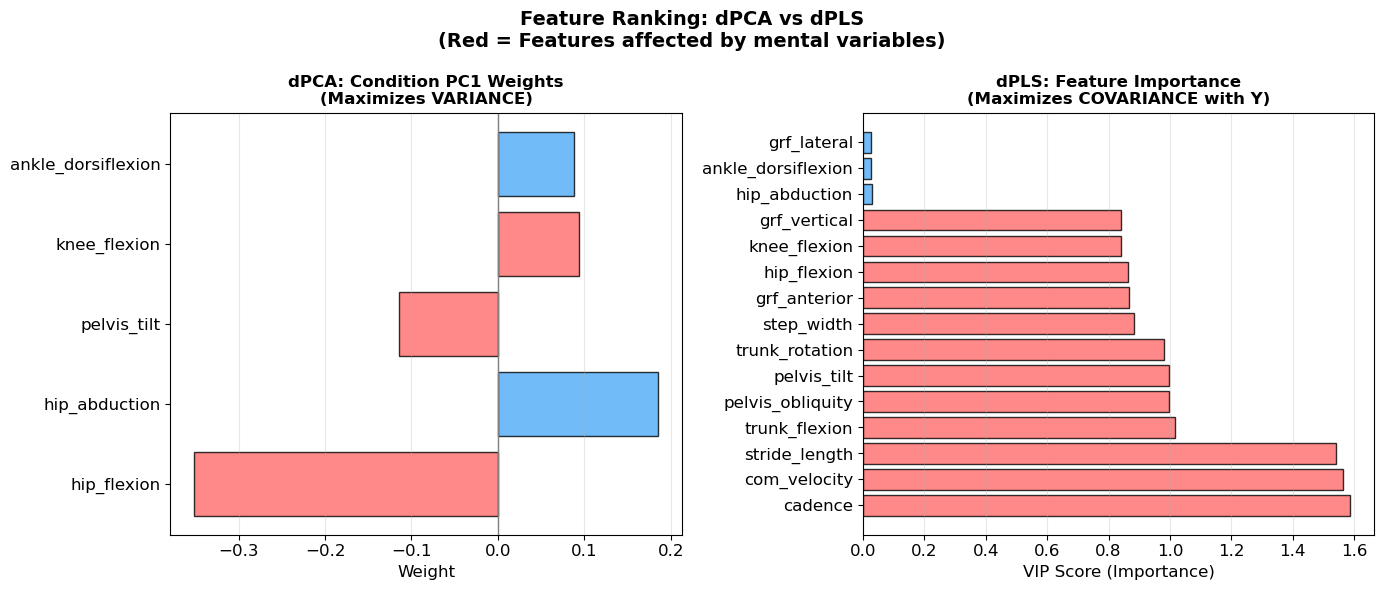

Legend: Red bars = features we designed to be affected by mental variables

Observation:
  - dPLS ranks features by their predictive power for ALL mental variables
  - dPCA finds features with most variance (not necessarily predictive)


In [5]:
# Compare feature weights: dPCA vs dPLS
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Get all features affected by any mental variable
all_affected_features = set()
for features in feature_mental_mapping.values():
    all_affected_features.update(features)

# dPCA: encoder weights for condition marginalization
ax1 = axes[0]
dpca_weights = dpca._encoder['condition'][0, :]  # First component
sorted_idx_pca = np.argsort(np.abs(dpca_weights))[::-1]
sorted_weights_pca = dpca_weights[sorted_idx_pca]
sorted_labels_pca = [feature_labels[i] for i in sorted_idx_pca]

colors_pca = ['#ff6b6b' if i in all_affected_features else '#4dabf7' for i in sorted_idx_pca]
ax1.barh(range(len(sorted_weights_pca)), sorted_weights_pca, color=colors_pca, alpha=0.8, edgecolor='black')
ax1.set_yticks(range(len(sorted_weights_pca)))
ax1.set_yticklabels(sorted_labels_pca)
ax1.set_xlabel('Weight')
ax1.set_title('dPCA: Condition PC1 Weights\n(Maximizes VARIANCE)', fontsize=12, fontweight='bold')
ax1.axvline(x=0, color='gray', lw=1)
ax1.grid(True, axis='x', alpha=0.3)

# dPLS: PLS weights for condition marginalization
ax2 = axes[1]
dpls_importance = dpls.get_feature_importance('condition')
dpls_weights = np.array([dpls_importance[f] for f in feature_labels])
sorted_idx_pls = np.argsort(dpls_weights)[::-1]
sorted_weights_pls = dpls_weights[sorted_idx_pls]
sorted_labels_pls = [feature_labels[i] for i in sorted_idx_pls]

colors_pls = ['#ff6b6b' if i in all_affected_features else '#4dabf7' for i in sorted_idx_pls]
ax2.barh(range(len(sorted_weights_pls)), sorted_weights_pls, color=colors_pls, alpha=0.8, edgecolor='black')
ax2.set_yticks(range(len(sorted_weights_pls)))
ax2.set_yticklabels(sorted_labels_pls)
ax2.set_xlabel('VIP Score (Importance)')
ax2.set_title('dPLS: Feature Importance\n(Maximizes COVARIANCE with Y)', fontsize=12, fontweight='bold')
ax2.grid(True, axis='x', alpha=0.3)

plt.suptitle('Feature Ranking: dPCA vs dPLS\n(Red = Features affected by mental variables)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("Legend: Red bars = features we designed to be affected by mental variables")
print("\nObservation:")
print("  - dPLS ranks features by their predictive power for ALL mental variables")
print("  - dPCA finds features with most variance (not necessarily predictive)")

## 3. Prediction: dPLS Can Predict Multiple Mental Variables

Unlike dPCA, dPLS is designed for prediction. With multivariate Y, it predicts ALL mental variables simultaneously.

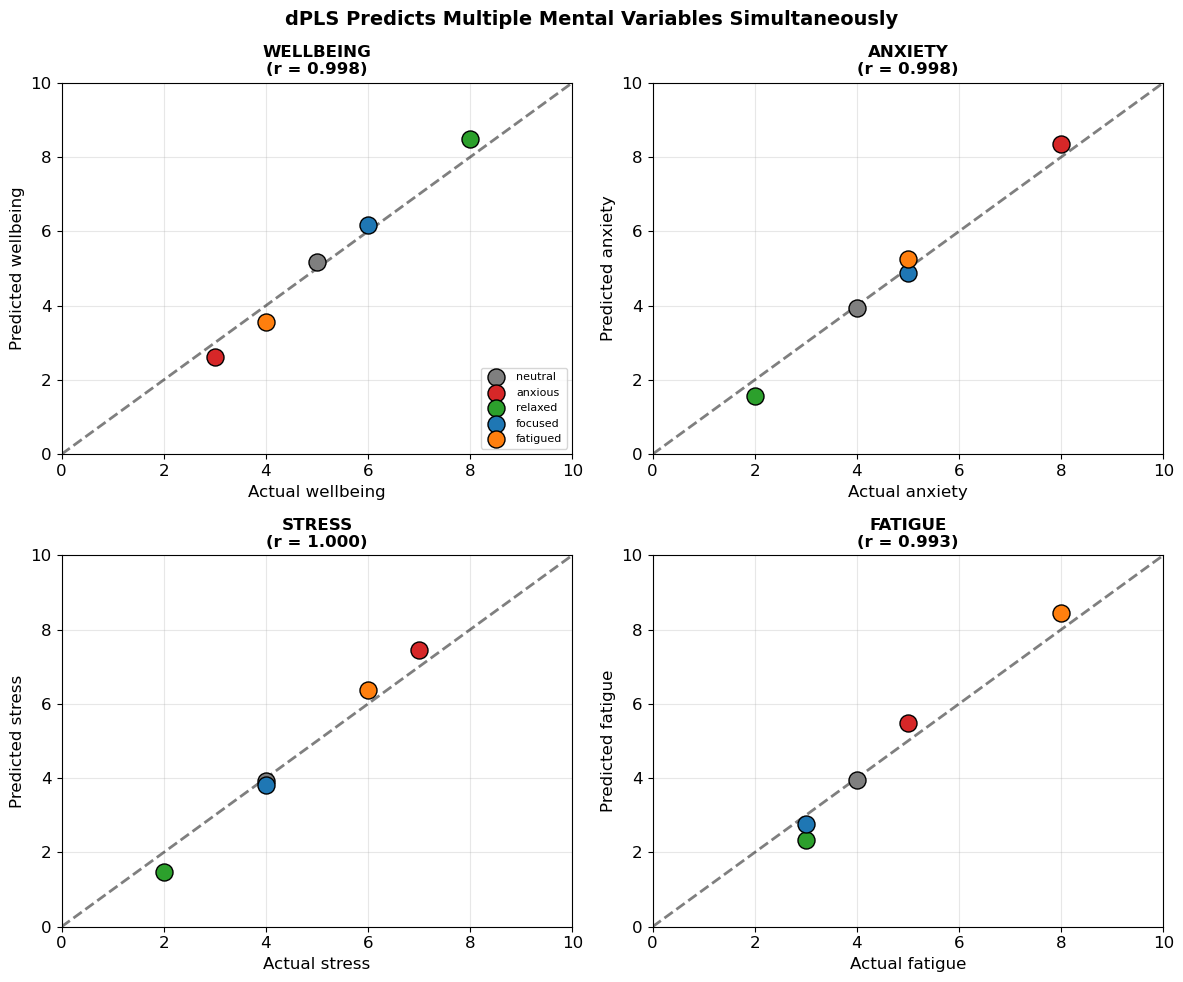

dPLS predicts ALL mental variables from gait patterns:
  Predicted shape: (5, 4) = [n_conditions, n_mental_vars]


In [6]:
# dPLS can predict MULTIVARIATE mental scores
predicted_scores = dpls.predict(data, marginalization='condition')

# Handle shape for multivariate prediction
if predicted_scores.ndim == 1:
    predicted_scores = predicted_scores.reshape(-1, 1)
    
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
colors = ['#7f7f7f', '#d62728', '#2ca02c', '#1f77b4', '#ff7f0e']

for m_idx, (ax, mental_var) in enumerate(zip(axes.flat, mental_labels)):
    actual = mental_scores[:, m_idx]
    if m_idx < predicted_scores.shape[1]:
        predicted = predicted_scores[:, m_idx]
    else:
        predicted = predicted_scores[:, 0]  # Use first component if fewer predictions
    
    for i, (label, color) in enumerate(zip(condition_labels, colors)):
        ax.scatter(actual[i], predicted[i], c=color, s=150, edgecolors='black', label=label, zorder=5)
    
    ax.plot([0, 10], [0, 10], 'k--', lw=2, alpha=0.5)
    corr = np.corrcoef(actual, predicted)[0, 1]
    ax.set_xlabel(f'Actual {mental_var}')
    ax.set_ylabel(f'Predicted {mental_var}')
    ax.set_title(f'{mental_var.upper()}\n(r = {corr:.3f})', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)

axes[0, 0].legend(loc='lower right', fontsize=8)
plt.suptitle('dPLS Predicts Multiple Mental Variables Simultaneously', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("dPLS predicts ALL mental variables from gait patterns:")
print(f"  Predicted shape: {predicted_scores.shape} = [n_conditions, n_mental_vars]")

## 4. Component Comparison: Time vs Condition

Both dPCA and dPLS separate time and condition components, but with different objectives.

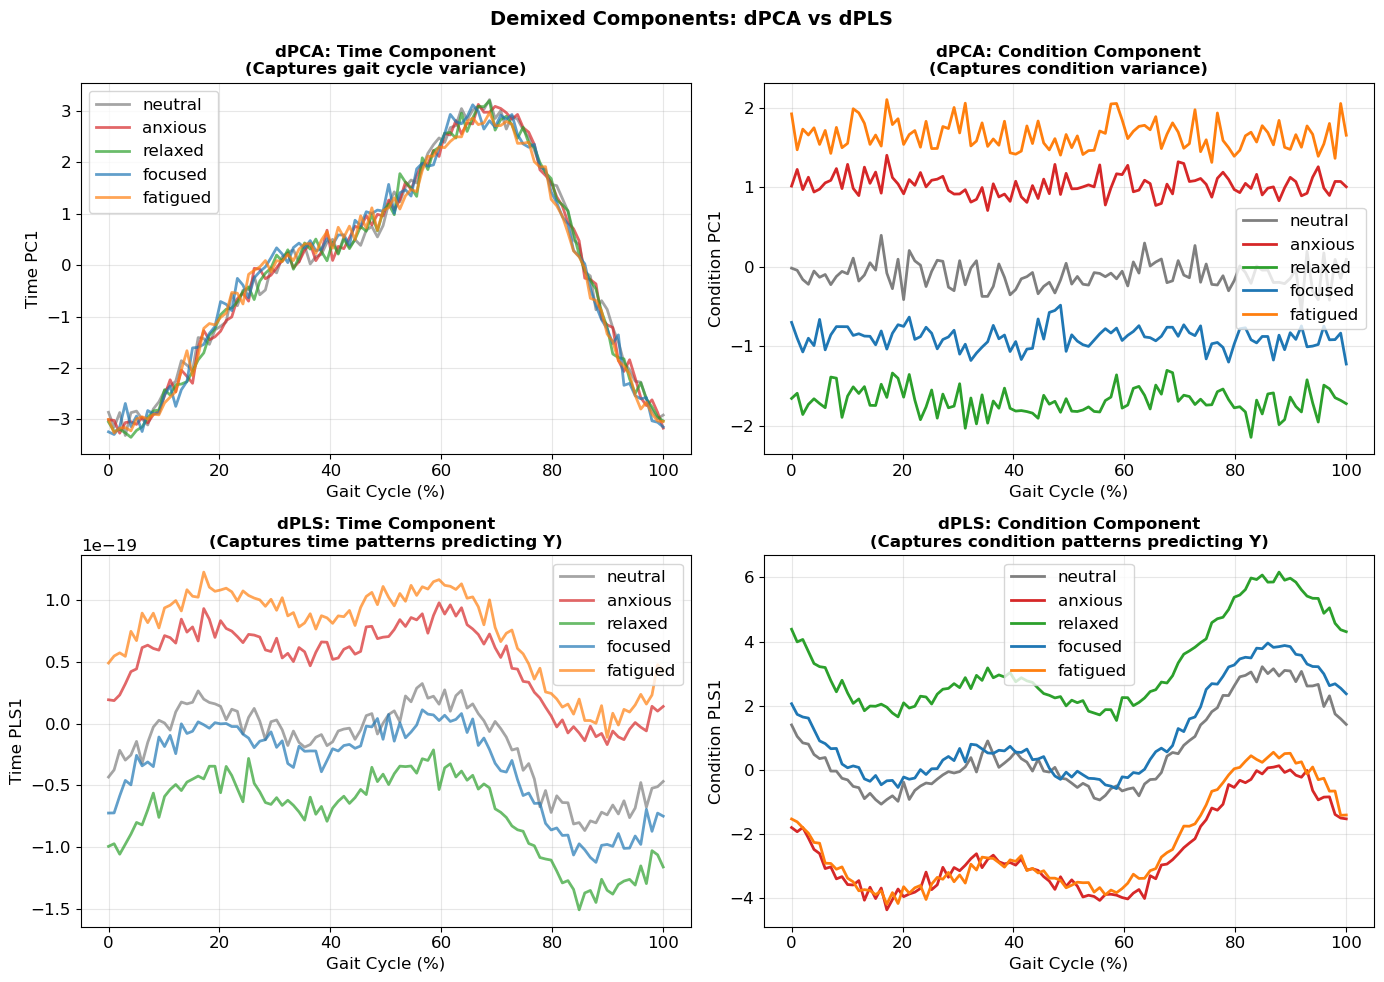

In [7]:
# Transform data with both methods
Z_pca = dpca.transform(data)
Z_pls = dpls.transform(data)

time_axis = np.linspace(0, 100, n_timepoints)
colors = ['#7f7f7f', '#d62728', '#2ca02c', '#1f77b4', '#ff7f0e']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# dPCA Time Component
ax1 = axes[0, 0]
for c_idx, (state, color) in enumerate(zip(condition_labels, colors)):
    ax1.plot(time_axis, Z_pca['time'][0, :, c_idx], label=state, color=color, lw=2, alpha=0.7)
ax1.set_xlabel('Gait Cycle (%)')
ax1.set_ylabel('Time PC1')
ax1.set_title('dPCA: Time Component\n(Captures gait cycle variance)', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# dPCA Condition Component
ax2 = axes[0, 1]
for c_idx, (state, color) in enumerate(zip(condition_labels, colors)):
    ax2.plot(time_axis, Z_pca['condition'][0, :, c_idx], label=state, color=color, lw=2)
ax2.set_xlabel('Gait Cycle (%)')
ax2.set_ylabel('Condition PC1')
ax2.set_title('dPCA: Condition Component\n(Captures condition variance)', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# dPLS Time Component
ax3 = axes[1, 0]
for c_idx, (state, color) in enumerate(zip(condition_labels, colors)):
    ax3.plot(time_axis, Z_pls['time'][0, :, c_idx], label=state, color=color, lw=2, alpha=0.7)
ax3.set_xlabel('Gait Cycle (%)')
ax3.set_ylabel('Time PLS1')
ax3.set_title('dPLS: Time Component\n(Captures time patterns predicting Y)', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# dPLS Condition Component
ax4 = axes[1, 1]
for c_idx, (state, color) in enumerate(zip(condition_labels, colors)):
    ax4.plot(time_axis, Z_pls['condition'][0, :, c_idx], label=state, color=color, lw=2)
ax4.set_xlabel('Gait Cycle (%)')
ax4.set_ylabel('Condition PLS1')
ax4.set_title('dPLS: Condition Component\n(Captures condition patterns predicting Y)', fontsize=12, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.suptitle('Demixed Components: dPCA vs dPLS', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 5. Summary

### dPCA vs dPLS Comparison

| | dPCA | dPLS |
|---|------|------|
| **Objective** | Max variance | Max covariance with Y |
| **Input** | X only | X and Y (multivariate) |
| **Output** | Variance-explaining components | Predictive components |
| **Feature selection** | High-variance features | Predictive features |
| **Can predict Y?** | ❌ No | ✅ Yes (all variables) |

### When to Use Each

**Use dPCA when:**
- You want to explore data structure
- You don't have target labels/scores
- You want to understand what patterns exist

**Use dPLS when:**
- You have mental scores to predict (single or multiple)
- You want to find which features predict which mental variables
- You need a predictive model for multiple outcomes

### Data Requirements

Both methods require:
```python
X.shape = [n_features, n_timepoints, n_conditions]
```

dPLS additionally requires:
```python
# Single mental variable
Y.shape = [n_conditions]

# Multiple mental variables (MULTIVARIATE)
Y.shape = [n_conditions, n_mental_vars]
# e.g., [5 conditions, 4 variables: wellbeing, anxiety, stress, fatigue]
```

### Available in This Package

```python
from src.dpca import DemixedPCA, DemixedPLS

# Unsupervised
dpca = DemixedPCA(n_components=5)
dpca.fit(X)

# Supervised with MULTIVARIATE mental scores
Y = np.array([
    [5.0, 4.0, 4.0, 4.0],  # neutral: [wellbeing, anxiety, stress, fatigue]
    [3.0, 8.0, 7.0, 5.0],  # anxious
    ...
])
dpls = DemixedPLS(n_components=5)
dpls.fit(X, Y)
Y_pred = dpls.predict(X_new)  # Predicts all mental variables
```